<a href="https://colab.research.google.com/github/NilakshanKunananthaseelan/MachineLearning/blob/main/DANN/DomainAdaptationMNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu' 


# Load mnist

In [2]:
from torchvision import transforms
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
               
                 ]), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
               
                 ]), 
)




  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



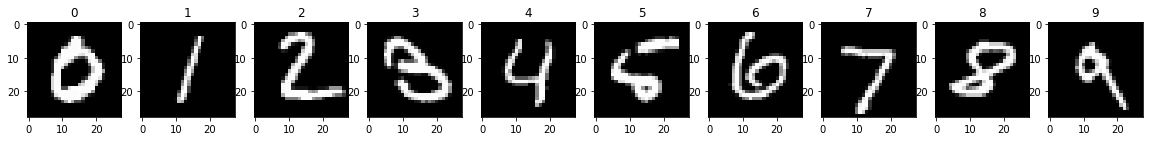

In [3]:

%matplotlib inline



plt.figure(figsize=(20, 15))
for i, digit in enumerate(test_data.targets.unique(),start=1):
    index = np.where(test_data.targets == digit)[0][0]
    ax = plt.subplot(1, 10, i)
    ax.imshow(test_data.data[index],cmap='gray')
    ax.set_title('%i' % test_data.targets[index])

## Create mnist-m

In [4]:
from __future__ import print_function

import errno
import os

import torch
import torch.utils.data as data
from PIL import Image


class MNISTM(data.Dataset):
    """`MNIST-M Dataset."""

    url = "https://github.com/VanushVaswani/keras_mnistm/releases/download/1.0/keras_mnistm.pkl.gz"

    raw_folder = "raw"
    processed_folder = "processed"
    training_file = "mnist_m_train.pt"
    test_file = "mnist_m_test.pt"

    def __init__(self, root, mnist_root="data", train=True, transform=None, target_transform=None, download=False):
        """Init MNIST-M dataset."""
        super(MNISTM, self).__init__()
        self.root = os.path.expanduser(root)
        self.mnist_root = os.path.expanduser(mnist_root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError("Dataset not found." + " You can use download=True to download it")

        if self.train:
            self.train_data, self.train_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.training_file)
            )
        else:
            self.test_data, self.test_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.test_file)
            )

    def __getitem__(self, index):
        """Get images and target for data loader.
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.squeeze().numpy(), mode="RGB")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        """Return size of dataset."""
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and os.path.exists(
            os.path.join(self.root, self.processed_folder, self.test_file)
        )

    def download(self):
        """Download the MNIST data."""
        # import essential packages
        from six.moves import urllib
        import gzip
        import pickle
        from torchvision import datasets

        # check if dataset already exists
        if self._check_exists():
            return

        # make data dirs
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        # download pkl files
        print("Downloading " + self.url)
        filename = self.url.rpartition("/")[2]
        file_path = os.path.join(self.root, self.raw_folder, filename)
        if not os.path.exists(file_path.replace(".gz", "")):
            data = urllib.request.urlopen(self.url)
            with open(file_path, "wb") as f:
                f.write(data.read())
            with open(file_path.replace(".gz", ""), "wb") as out_f, gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        # process and save as torch files
        print("Processing...")

        # load MNIST-M images from pkl file
        with open(file_path.replace(".gz", ""), "rb") as f:
            mnist_m_data = pickle.load(f, encoding="bytes")
        mnist_m_train_data = torch.ByteTensor(mnist_m_data[b"train"])
        mnist_m_test_data = torch.ByteTensor(mnist_m_data[b"test"])

        # get MNIST labels
        mnist_train_labels = datasets.MNIST(root=self.mnist_root, train=True, download=True).train_labels
        mnist_test_labels = datasets.MNIST(root=self.mnist_root, train=False, download=True).test_labels

        # save MNIST-M dataset
        training_set = (mnist_m_train_data, mnist_train_labels)
        test_set = (mnist_m_test_data, mnist_test_labels)
        with open(os.path.join(self.root, self.processed_folder, self.training_file), "wb") as f:
            torch.save(training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.test_file), "wb") as f:
            torch.save(test_set, f)

        print("Done!")

In [5]:
train_mdata = MNISTM(
    root = 'data',
    train = True,                         
    transform =  transforms.Compose([
                transforms.ToTensor()               
                 ]),  
    download = True,            
)
test_mdata = MNISTM(
    root = 'data', 
    train = False, 
    transform =  transforms.Compose([
                transforms.ToTensor()               
                 ]), 
)

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Done!


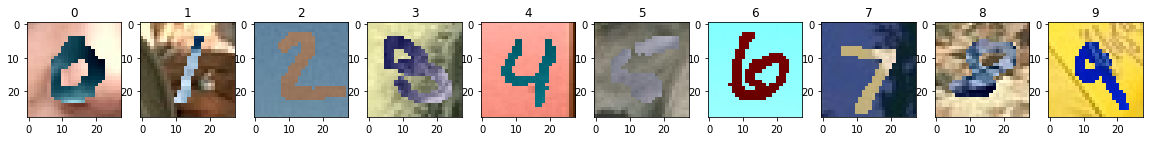

In [6]:
%matplotlib inline

plt.figure(figsize=(20, 15))
for i, digit in enumerate(test_mdata.test_labels.unique(),start=1):
    index = np.where(test_mdata.test_labels == digit)[0][0]
    ax = plt.subplot(1, 10, i)
    ax.imshow(test_mdata.test_data[index],cmap='gray')
    ax.set_title('%i' % test_mdata.test_labels[index])

In [7]:
test_data[0][0].shape,test_mdata[0][0].shape

(torch.Size([3, 28, 28]), torch.Size([3, 28, 28]))

# Naive model

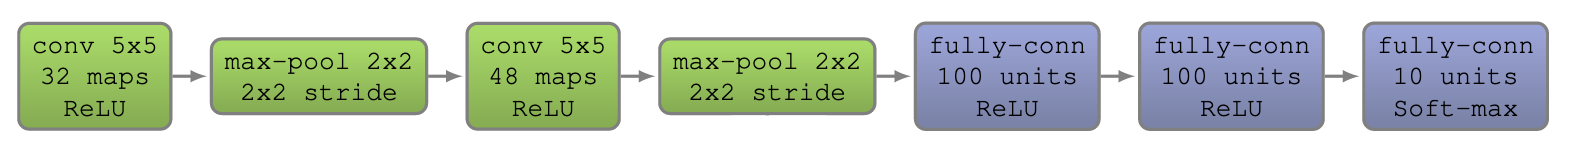

Model definition

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    self.conv1 = nn.Conv2d(3,32,5)
    self.relu1 = nn.ReLU(inplace=True)
    self.maxpool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(32,48,5)
    self.relu2 = nn.ReLU(inplace=True)
    self.maxpool2 = nn.MaxPool2d(2,2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(48*4*4,100)
    self.fc2 = nn.Linear(100,100)
    self.fc3 = nn.Linear(100,10)


  def forward(self,x):
    out = self.relu1(self.conv1(x))
    out = self.maxpool1(out)
    out = self.relu2(self.conv2(out))
    out = self.maxpool2(out)
    out = self.flatten(out)

    out = nn.functional.relu(self.fc1(out))
    out = nn.functional.relu(self.fc2(out))
    logits = self.fc3(out)


    return logits




In [9]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.feature_extractor = nn.Sequential(nn.Conv2d(3,32,5),
                                           nn.ReLU(inplace=True),
                                           nn.MaxPool2d(2,2),
                                           nn.Conv2d(32,48,5),
                                           nn.ReLU(inplace=True),
                                           nn.MaxPool2d(2,2)

                                           )
    self.flatten = nn.Flatten()
    self.class_classifier = nn.Sequential(nn.Linear(48*4*4,100),nn.ReLU(inplace=True),nn.Linear(100,100),nn.ReLU(inplace=True),nn.Linear(100,10))



  def forward(self,x):
    out = self.feature_extractor(x)
  
    out = self.flatten(out)

    logits = self.class_classifier(out)


    return logits




In [10]:
model = Net()
model

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (class_classifier): Sequential(
    (0): Linear(in_features=768, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)

Define optimizer and loss function

In [11]:

loss_fn = nn.CrossEntropyLoss()
optimizer = optimizer = optim.Adam(model.parameters(), lr = 0.01)   


Define dataloaders

Shape of X [N, C, H, W]:  torch.Size([128, 3, 28, 28])
Shape of y:  torch.Size([128]) torch.int64


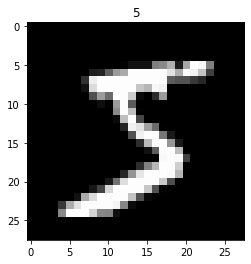

Shape of X [N, C, H, W]:  torch.Size([128, 3, 28, 28])
Shape of y:  torch.Size([128]) torch.int64


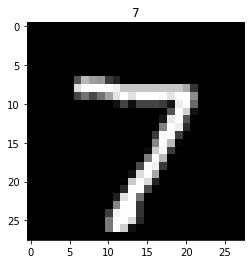

In [12]:

batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)

    plt.imshow(X[0].squeeze(0).permute(1,2,0), cmap='gray')
    plt.title('%i' % y[0])
    plt.show()
    break

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)

    plt.imshow(X[0].squeeze(0).permute(1,2,0), cmap='gray')
    plt.title('%i' % y[0])
    plt.show()
    break

Shape of X [N, C, H, W]:  torch.Size([128, 3, 28, 28])
Shape of y:  torch.Size([128]) torch.int64


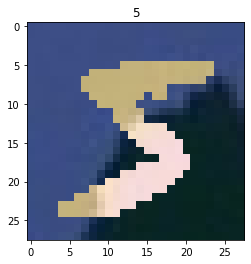

Shape of X [N, C, H, W]:  torch.Size([128, 3, 28, 28])
Shape of y:  torch.Size([128]) torch.int64


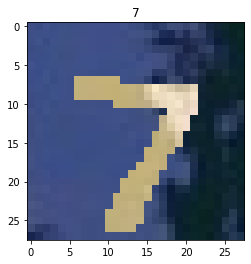

In [13]:
# Create data loaders.
train_mdataloader = DataLoader(train_mdata, batch_size=batch_size)
test_mdataloader = DataLoader(test_mdata, batch_size=batch_size)

for X, y in train_mdataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)

    plt.imshow(X[0].squeeze(0).permute(1,2,0), cmap='gray')
    plt.title('%i' % y[0])
    plt.show()
    break

for X, y in test_mdataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)

    plt.imshow(X[0].squeeze(0).permute(1,2,0), cmap='gray')
    plt.title('%i' % y[0])
    plt.show()
    break

Train and test functions

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [15]:
epochs = 5
model = model.to(device)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.312287  [    0/60000]
loss: 0.136728  [12800/60000]
loss: 0.122409  [25600/60000]
loss: 0.086337  [38400/60000]
loss: 0.229539  [51200/60000]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.100409 

Epoch 2
-------------------------------
loss: 0.057067  [    0/60000]
loss: 0.067514  [12800/60000]
loss: 0.102652  [25600/60000]
loss: 0.079201  [38400/60000]
loss: 0.177393  [51200/60000]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.077397 

Epoch 3
-------------------------------
loss: 0.070927  [    0/60000]
loss: 0.029212  [12800/60000]
loss: 0.056360  [25600/60000]
loss: 0.074658  [38400/60000]
loss: 0.161009  [51200/60000]
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.133944 

Epoch 4
-------------------------------
loss: 0.088712  [    0/60000]
loss: 0.050012  [12800/60000]
loss: 0.058156  [25600/60000]
loss: 0.072032  [38400/60000]
loss: 0.077408  [51200/60000]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.110871 

Epoch 5
------------------------

In [16]:
print('Evaluation on MNIST \n')
test(test_dataloader, model, loss_fn)

print('Evaluation on MNIST-M \n')
test(test_mdataloader, model, loss_fn)


Evaluation on MNIST 

Test Error: 
 Accuracy: 98.7%, Avg loss: 0.071203 

Evaluation on MNIST-M 

Test Error: 
 Accuracy: 25.3%, Avg loss: 2.139339 



# Model with Gradient Reveresal Layer

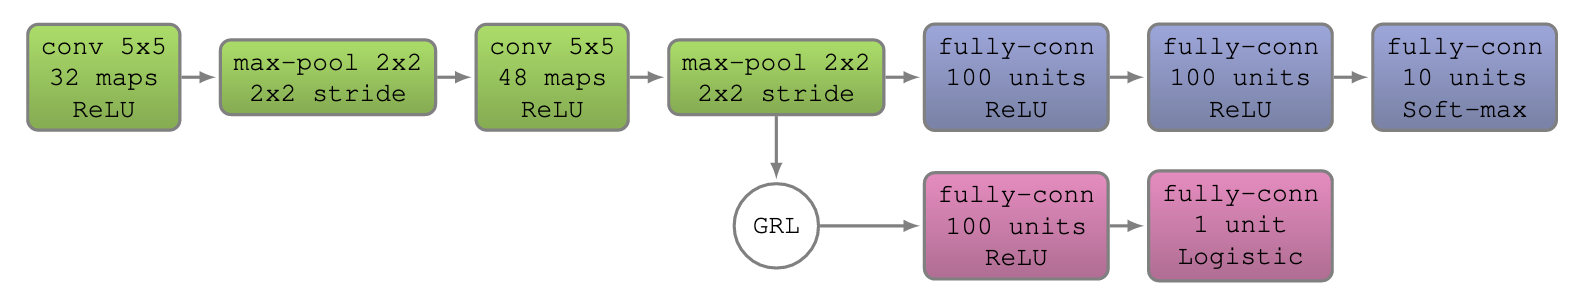


GRL 

In [17]:
import torch
import torch.nn as nn
from torch.autograd import Function
import pytest
from copy import deepcopy

class GradientReversal(Function):
  """
  This custom autograd class implements gradient reersal function
  """

  @staticmethod
  def forward(ctx, input,lamda):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input,lamda)
        output  = input
        return output

  @staticmethod
  def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input,lamda = ctx.saved_tensors
        grad_input = None
        if ctx.needs_input_grad[0]:
          grad_input = grad_output.neg()*lamda


        return grad_input,None
class GradientReversalLayer(nn.Module):
  def __init__(self,lamda=1.0,*args,**kwargs):
    """
    A gradient reversal layer

    This layer only reverses the gradient(sometimes multiplies with a non-zero constant) in the backward propagation

    grad_input = -grad_outpu*alpha
    """

    super().__init__(*args,**kwargs)

    self.lamda = torch.tensor(lamda,requires_grad=False)
             

  def forward(self,x):
    return GradientReversal.apply(x,self.lamda)

In [18]:
class DANNv1(nn.Module):
  def __init__(self,lamda):
    super(DANNv1,self).__init__()

    self.feature_extractor  = Net().feature_extractor
    self.flatten = nn.Flatten()
    self.grl = GradientReversalLayer(lamda=lamda)

    self.class_classifier  = Net().class_classifier

    self.domain_classifier = nn.Sequential(nn.Linear(48*4*4,100),nn.ReLU(inplace=True),nn.Linear(100,1),nn.Sigmoid())

  def forward(self,x):
    feature = self.flatten(self.feature_extractor(x))
    class_out = self.class_classifier(feature)

    reverse_feature = self.grl(feature)
    domain_out = self.domain_classifier(reverse_feature)

    return class_out,domain_out


In [19]:
x = torch.ones((128,3,28,28)).float().to('cuda')
dann = DANNv1(lamda=1.0).to('cuda')
c,d = dann(x)
c.shape,d.shape

(torch.Size([128, 10]), torch.Size([128, 1]))

Shape of X [N, C, H, W]:  torch.Size([128, 3, 28, 28])
Shape of y:  torch.Size([128]) torch.int64


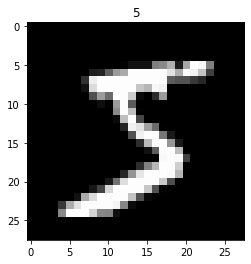

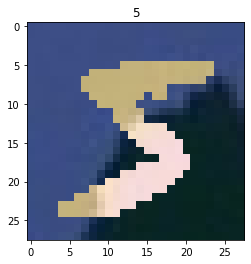

In [20]:
for i, (source_data, target_data) in enumerate(zip(train_dataloader, train_mdataloader)):

  X_src,y_src = source_data
  X_tgt,y_tgt = target_data

  print("Shape of X [N, C, H, W]: ", X_src.shape)
  print("Shape of y: ", y_src.shape, y_src.dtype)

  plt.imshow(X_src[0].squeeze(0).permute(1,2,0), cmap='gray')
  plt.title('%i' % y_src[0])
  plt.show()

  plt.imshow(X_tgt[0].squeeze(0).permute(1,2,0))
  plt.title('%i' % y_tgt[0])
  plt.show()

  break

In [21]:
from torch.autograd import Variable, Function
import datetime

In [26]:
class DomainAdaptation(object):
  def __init__(self,source_trainloader,source_testloader,target_trainloader,device='cuda'):
    self.source_trainloader = source_trainloader
    self.source_testloader = source_testloader
    self.target_trainloader = target_trainloader

    self.num_classes = 10
    self.device = device
    self.batch_size = self.source_trainloader.batch_size
    print(self.batch_size)
    self.model = DANNv1(lamda = 1.0).to(self.device)
    # self.optimizer = optim.Adam(model.parameters(), lr = 0.01)  
    self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, betas=(0.8, 0.999))
    self.loss_fn_cls = nn.CrossEntropyLoss()
    self.loss_fn_d = nn.BCELoss()

    self.real_class = 1
    self.fake_class = 0
    self.best_val = 0

    for p in self.model.parameters():
            p.requires_grad = True

  def test(self, epoch):
     
        # self.model.load_state_dict(torch.load('./best_dann.pth'))
        
        self.model.eval()
        total = 0
        correct = 0
        with torch.no_grad():
          for i, tgt_data in enumerate(self.target_trainloader):
              tgt_image, tgt_label = tgt_data
              tgt_image = tgt_image.cuda()
              tgt_image = Variable(tgt_image)

              class_out, _ = self.model(tgt_image)
              
              _, predicted = torch.max(class_out.data, 1)
              total += tgt_label.size(0)
              correct += ((predicted == tgt_label.cuda()).sum())

        test_acc = 100*float(correct)/total
        print('\n%s| Epoch: %d, Test Accuracy: %f %%' % (datetime.datetime.now(), epoch, test_acc))

        return test_acc

  def train(self,num_epochs=5):
    
  
    min_len = min(len(self.source_trainloader),len(self.target_trainloader))
    print_frequency = min_len//2
    for epoch in range(num_epochs):
      self.model.train()
      for i, (source_data, target_data) in enumerate(zip(self.source_trainloader, self.target_trainloader)):

        X_src,y_src = source_data
        X_tgt,y_tgt = target_data

        X_src = X_src.to(self.device)
        y_src = y_src.to(self.device)
        X_tgt = X_tgt.to(self.device)

        self.model.zero_grad()
        # print(X_src.shape)
        class_out, domain_out = self.model(X_src)

        
        fake_class = torch.zeros_like(domain_out)

        # print(class_out.shape,domain_out.shape,fake_class.shape,real_class.shape)

        class_err = self.loss_fn_cls(class_out, y_src)
        src_domain_err = self.loss_fn_d(domain_out, fake_class)

        _, domain_out = self.model(X_tgt)
        real_class = torch.ones_like(domain_out)
        tgt_domain_err = self.loss_fn_d(domain_out, real_class)

        total_loss = class_err + src_domain_err + tgt_domain_err

        total_loss.backward()
        self.optimizer.step()

        if i % print_frequency == 0:
            print('epoch: {0}| {1}/{2}  class_err: {c:.4f}  src_err: {s:.4f}  tgt_err: {t:.4f}'.format(
                epoch, i, min_len, c=class_err.data.item(), s=src_domain_err.data.item(), t=tgt_domain_err.data.item()
            ))

      torch.save(self.model.state_dict(), './dann.pth')
      test_acc = self.test(epoch+1)
      # self.validate(epoch+1)

      if test_acc > self.best_val:
          self.best_val = test_acc
          torch.save(self.model.state_dict(), './best_dann.pth')





In [27]:
da = DomainAdaptation(train_dataloader,test_dataloader,train_mdataloader)
da.train(num_epochs=50)

128
epoch: 0| 0/469  class_err: 2.3005  src_err: 0.7030  tgt_err: 0.6860
epoch: 0| 234/469  class_err: 0.5202  src_err: 0.4450  tgt_err: 0.6316
epoch: 0| 468/469  class_err: 0.5632  src_err: 0.7020  tgt_err: 0.1841

2021-12-29 17:08:27.159105| Epoch: 1, Test Accuracy: 31.250000 %
epoch: 1| 0/469  class_err: 0.3637  src_err: 0.1934  tgt_err: 0.5181
epoch: 1| 234/469  class_err: 0.2720  src_err: 0.6416  tgt_err: 0.5135
epoch: 1| 468/469  class_err: 0.4767  src_err: 0.2775  tgt_err: 1.3250

2021-12-29 17:09:02.734312| Epoch: 2, Test Accuracy: 44.786667 %
epoch: 2| 0/469  class_err: 0.3293  src_err: 0.6084  tgt_err: 0.7596
epoch: 2| 234/469  class_err: 0.1793  src_err: 0.5014  tgt_err: 0.8083
epoch: 2| 468/469  class_err: 0.3909  src_err: 0.6786  tgt_err: 0.9286

2021-12-29 17:09:38.931990| Epoch: 3, Test Accuracy: 47.186667 %
epoch: 3| 0/469  class_err: 0.2445  src_err: 0.9566  tgt_err: 0.5340
epoch: 3| 234/469  class_err: 0.1723  src_err: 0.4581  tgt_err: 0.6664
epoch: 3| 468/469  class_

In [32]:
def test(model,target_trainloader):
     
        # self.model.load_state_dict(torch.load('./best_dann.pth'))
        
        model.eval()
        total = 0
        correct = 0
        with torch.no_grad():
          for i, tgt_data in enumerate(target_trainloader):
            
              tgt_image, tgt_label = tgt_data
              tgt_image = tgt_image.cuda()
              tgt_image = Variable(tgt_image)

              class_out, _ = model(tgt_image)
              
              _, predicted = torch.max(class_out.data, 1)
              total += tgt_label.size(0)
              correct += ((predicted == tgt_label.cuda()).sum())
              # for j in range(10):
              #   plt.imshow(tgt_image[j].squeeze(0).permute(1,2,0).cpu().numpy())
              #   plt.title('%i %i' % (tgt_label[j],predicted[j]))
              #   plt.show()


        test_acc = 100*float(correct)/total
        print('%s| Test Accuracy: %f %%' % (datetime.datetime.now(), test_acc))

        return test_acc


In [33]:
len(test_mdataloader)

79

In [35]:
test(da.model,train_mdataloader)

2021-12-29 17:43:58.028493| Test Accuracy: 57.220000 %


57.22